In [ ]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn
import torch
import numpy as np
import matplotlib.pyplot as plt

TRAIN_DATASET = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())
VAL_DATASET = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_data = DataLoader(TRAIN_DATASET, batch_size = 256, shuffle=True)
val_data = DataLoader(VAL_DATASET, batch_size = 256, shuffle=True)

(b)

In [ ]:
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

model = allcnn_t().to(device)
optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.001, lr=1e-4, momentum=0.9)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1.1)

Num parameters:  1667166


In [ ]:
def train(model):

  epochs = 1
  loss_list=[]
  lr_list=[]

  for epoch in range(epochs):
      for i, data in enumerate(train_data):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          outputs = model(inputs)

          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          lr_list.append(optimizer.param_groups[0]['lr'])
          scheduler.step()

          loss_list.append(loss.item())
        
      print('Epoch:',epoch+1,'Average loss:',np.mean(loss_list[epoch*i:(epoch+1)*i]))
  
  plt.plot(np.log(lr_list),loss_list)
  plt.xlabel('log scale learning rate')
  plt.ylabel('Training loss')

  return model, lr_list, loss_list

model, lr_list, loss_list = train(model)

KeyboardInterrupt: ignored

Text(0, 0.5, 'Training loss')

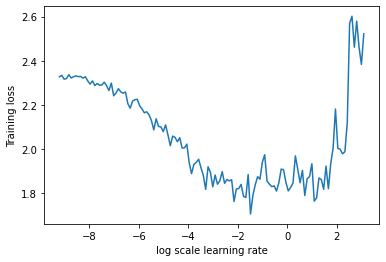

In [ ]:
plt.plot(np.log(lr_list[:130]),loss_list[:130])
plt.xlabel('log scale learning rate')
plt.ylabel('Training loss')

(c)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
def evaluate(model, data):
  loss_list=[]
  error_list=[]
  with torch.no_grad():
      for data in data:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        error_list.append(1-accuracy_score(np.argmax(outputs.detach().cpu().numpy(),axis=1), labels.detach().cpu().numpy()))


  return np.mean(loss_list), np.mean(error_list)

In [ ]:
def train1(model,optimizer,criterion,epoch,n):

  epochs = epoch
  lr_list=[]
  loss_list=[]
  error_list=[]
  val_loss_list=[]
  val_error_list=[]

  t = 0
  T = len(train_data)*epochs
  T0 = T//5


  for epoch in range(epochs):
      for i, data in enumerate(train_data):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()

          if t<=T0:
            optimizer.param_groups[0]['lr'] = 1e-4+(t/T0)*n
          else:
            optimizer.param_groups[0]['lr'] = 1e-6+n*np.cos((np.pi/2)*((t-T0)/(T-T0)))

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          loss_list.append(loss.item())
          error_list.append(1-accuracy_score(np.argmax(outputs.detach().cpu().numpy(),axis=1), labels.detach().cpu().numpy()))
          lr_list.append(optimizer.param_groups[0]['lr'])

          t += 1
        
      val_loss, val_error = evaluate(model,val_data)
      val_loss_list.append(val_loss)
      val_error_list.append(val_error)

      print('Epoch:',epoch+1,'Average loss:',np.mean(loss_list[epoch*i:(epoch+1)*i]),'Validation loss:',val_loss,'Validation Error:',val_error)

  
  plt.plot(loss_list,label='training loss')
  plt.plot(lr_list,label='learning rate')
  plt.xlabel('number of weights update')
  plt.ylabel('Training loss')
  plt.show()

  plt.plot(val_loss_list,label='loss')
  plt.plot(val_error_list,label='error')
  plt.xlabel('number of epoch')
  plt.show()


  return model, lr_list,loss_list,val_loss_list,error_list,val_error_list

In [ ]:
def draw_plot(lr_list,loss_list,val_loss_list,error_list,val_error_list):
  fig = plt.figure(figsize=(5,20))

  ax1 = fig.add_subplot(511)
  ax1.plot(lr_list,label='learning rate')
  ax1.set_xlabel('number of iteration')
  plt.legend()

  ax2 = fig.add_subplot(512)
  ax2.plot(loss_list,label='Training Loss')
  ax2.set_xlabel('number of iteration')
  plt.legend()

  ax3 = fig.add_subplot(513)
  ax3.plot(val_loss_list,label='Validation Loss')
  ax3.set_xlabel('number of iteration')
  plt.legend()

  ax4 = fig.add_subplot(514)
  ax4.plot(error_list,label='Training Error')
  ax4.set_xlabel('number of epoch')
  plt.legend()

  ax5 = fig.add_subplot(515)
  ax5.plot(val_error_list,label='Validation Error')
  ax5.set_xlabel('number of epoch')
  plt.legend()

Num parameters:  1667166
Epoch: 1 Average loss: 2.004451298713684 Validation loss: 1.7399830907583236 Validation Error: 0.6091796875
Epoch: 2 Average loss: 1.6044401376675337 Validation loss: 1.4785150557756424 Validation Error: 0.51640625
Epoch: 3 Average loss: 1.3674271173966237 Validation loss: 1.2881866425275803 Validation Error: 0.4509765625
Epoch: 4 Average loss: 1.1845562604757456 Validation loss: 1.1468330770730972 Validation Error: 0.39892578125
Epoch: 5 Average loss: 1.053941506300217 Validation loss: 1.0249104037880898 Validation Error: 0.353515625
Epoch: 6 Average loss: 0.9382262703699943 Validation loss: 0.8975427344441413 Validation Error: 0.313671875
Epoch: 7 Average loss: 0.8295472508821732 Validation loss: 0.8099442481994629 Validation Error: 0.2814453125
Epoch: 8 Average loss: 0.7479779081466871 Validation loss: 0.7643662706017494 Validation Error: 0.26171875
Epoch: 9 Average loss: 0.6928501278926165 Validation loss: 0.7146992638707161 Validation Error: 0.24365234375


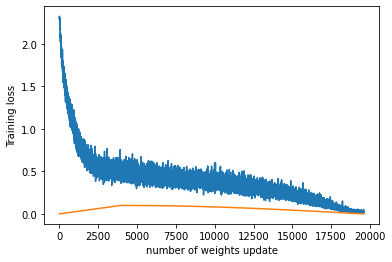

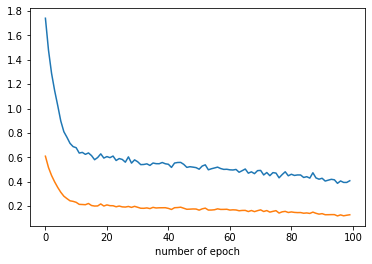

TypeError: ignored

In [ ]:
n=0.1
model1 = allcnn_t().to(device)
optimizer1 = torch.optim.SGD(model1.parameters(), weight_decay=0.001, lr=0.0001, momentum=0.9)
criterion1 = nn.CrossEntropyLoss()

model1, lr_list1, loss_list1, error_list1, val_loss_list1, val_error_list1 = train1(model1,optimizer1,criterion1,100,n)

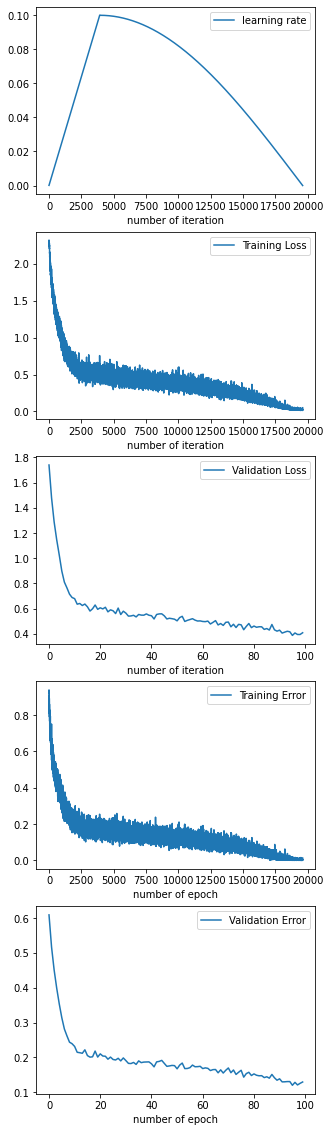

In [ ]:
draw_plot(lr_list1, loss_list1, error_list1, val_loss_list1, val_error_list1)

(d)

In [ ]:
def tune_model(n,r):
  model = allcnn_t().to(device)
  optimizer = torch.optim.SGD(model.parameters(), weight_decay=0.001, lr=0.0001, momentum=r)
  criterion = nn.CrossEntropyLoss()

  model, lr_list,loss_list,val_loss_list,error_list,val_error_list = train1(model,optimizer, criterion,50,n)
  draw_plot(lr_list,loss_list,val_loss_list,error_list,val_error_list)

  return model, lr_list,loss_list,val_loss_list,error_list,val_error_list

(i) max = 0.1, r = 0.9

Num parameters:  1667166
Epoch: 1 Average loss: 1.9162248452504476 Validation loss: 1.6346538454294204 Validation Error: 0.57333984375
Epoch: 2 Average loss: 1.4943359802930782 Validation loss: 1.378810355067253 Validation Error: 0.481640625
Epoch: 3 Average loss: 1.2512108234258799 Validation loss: 1.169642660021782 Validation Error: 0.41357421875
Epoch: 4 Average loss: 1.0731221770628905 Validation loss: 1.0217876195907594 Validation Error: 0.36142578125
Epoch: 5 Average loss: 0.926659124936813 Validation loss: 0.9060644105076789 Validation Error: 0.3181640625
Epoch: 6 Average loss: 0.8192527511180976 Validation loss: 0.8117719173431397 Validation Error: 0.28427734375
Epoch: 7 Average loss: 0.7398153396753164 Validation loss: 0.7705203518271446 Validation Error: 0.27255859375
Epoch: 8 Average loss: 0.6868411314793123 Validation loss: 0.7168522000312805 Validation Error: 0.24248046875
Epoch: 9 Average loss: 0.6453370513060154 Validation loss: 0.6895384952425957 Validation Error: 0.229

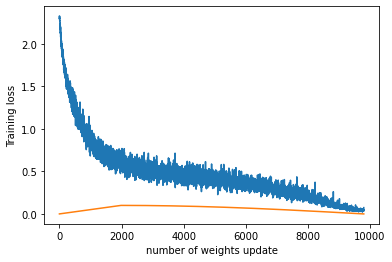

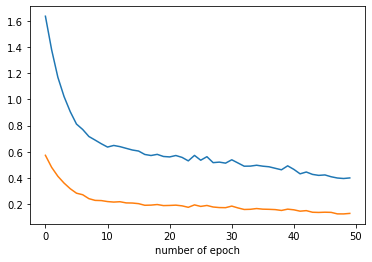

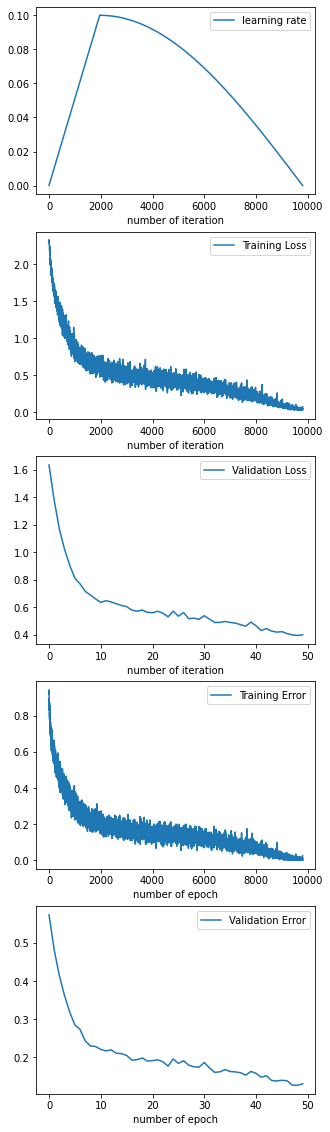

In [ ]:
model2, lr_list2, loss_list2, error_list2, val_loss_list2, val_error_list2 = tune_model(0.1,0.9)

(ii) max = 0.5, r = 0.5

Num parameters:  1667166
Epoch: 1 Average loss: 1.9102739529731947 Validation loss: 1.6648197919130325 Validation Error: 0.6029296875
Epoch: 2 Average loss: 1.4893017897239098 Validation loss: 1.4359309315681457 Validation Error: 0.51904296875
Epoch: 3 Average loss: 1.2400886847422674 Validation loss: 1.1849759727716447 Validation Error: 0.4166015625
Epoch: 4 Average loss: 1.0692341645558676 Validation loss: 1.2059892803430556 Validation Error: 0.42763671875
Epoch: 5 Average loss: 0.9461917599042257 Validation loss: 1.007996316254139 Validation Error: 0.3548828125
Epoch: 6 Average loss: 0.8285715751158885 Validation loss: 0.8557101562619209 Validation Error: 0.3041015625
Epoch: 7 Average loss: 0.7542680942095243 Validation loss: 0.7948429852724075 Validation Error: 0.28056640625
Epoch: 8 Average loss: 0.6993205269177755 Validation loss: 0.8005278781056404 Validation Error: 0.27861328125
Epoch: 9 Average loss: 0.6559882775331155 Validation loss: 0.8150949880480767 Validation Error: 0.27

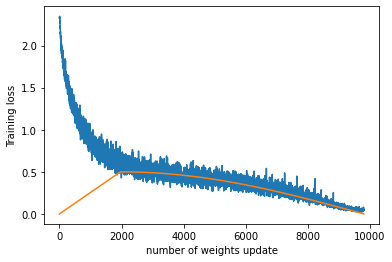

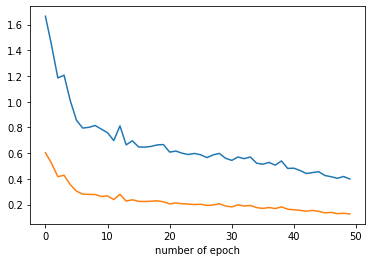

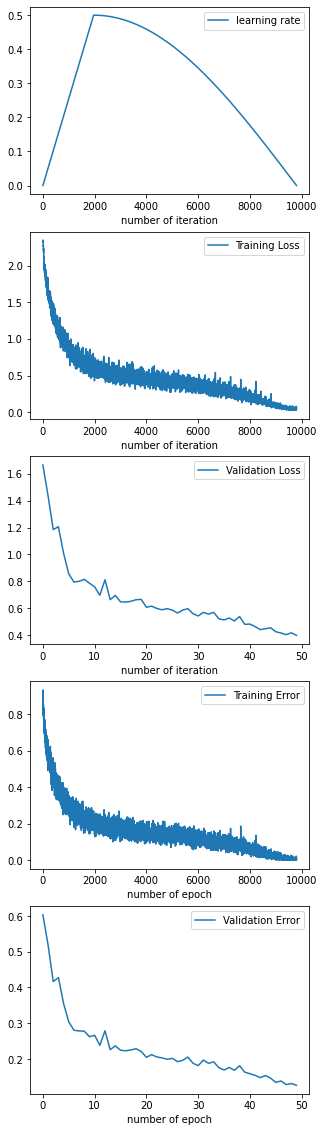

In [ ]:
model3, lr_list3, loss_list3, error_list3, val_loss_list3, val_error_list3 = tune_model(0.5,0.5)

(iii) max = 0.1, r = 0.5

Num parameters:  1667166
Epoch: 1 Average loss: 2.076725703630692 Validation loss: 1.8436362087726592 Validation Error: 0.651171875
Epoch: 2 Average loss: 1.7295220558459943 Validation loss: 1.619756382703781 Validation Error: 0.5673828125
Epoch: 3 Average loss: 1.5318488096579528 Validation loss: 1.514500504732132 Validation Error: 0.5357421875
Epoch: 4 Average loss: 1.3732956293301704 Validation loss: 1.3321003854274749 Validation Error: 0.4740234375
Epoch: 5 Average loss: 1.2375219846383119 Validation loss: 1.1921200305223465 Validation Error: 0.41171875
Epoch: 6 Average loss: 1.125124548948728 Validation loss: 1.142230173945427 Validation Error: 0.40078125
Epoch: 7 Average loss: 1.028477599681952 Validation loss: 1.0637878209352494 Validation Error: 0.3708984375
Epoch: 8 Average loss: 0.9254024542295016 Validation loss: 1.0451119229197503 Validation Error: 0.3650390625
Epoch: 9 Average loss: 0.8359506613168961 Validation loss: 0.9157079875469207 Validation Error: 0.32373046875
Epoc

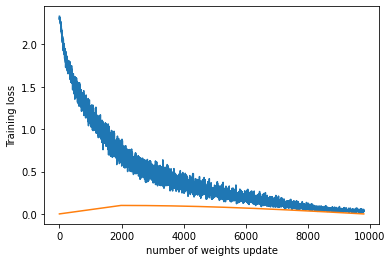

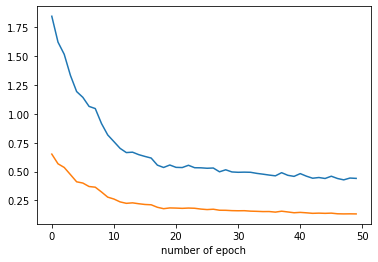

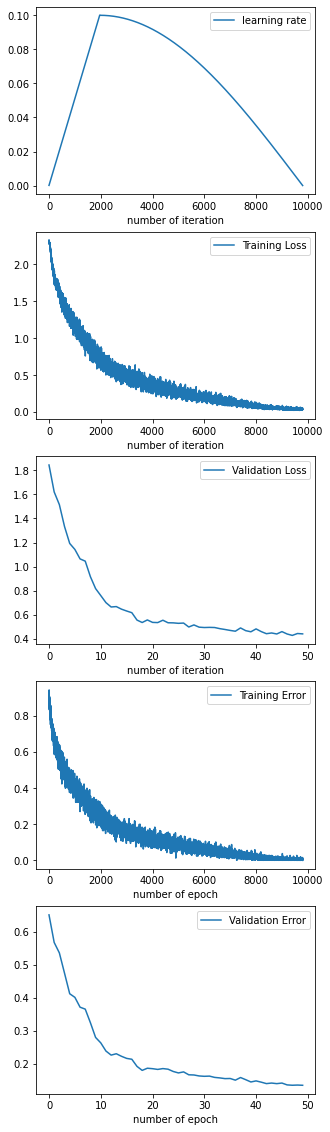

In [ ]:
model4, lr_list4, loss_list4, error_list4, val_loss_list4, val_error_list4 = tune_model(0.1,0.5)